# Mock AlphaGo (2) - Policy Network
In this notebook, we will build the model of AlphaGo's Policy Network, which is a dCNN.

In [1]:
import os, numpy as np
from caffe2.python import core, model_helper, workspace, brew, utils
from caffe2.proto import caffe2_pb2

%matplotlib inline
from matplotlib import pyplot

CONV_LEVEL = 13 # [3,13(alphago)] How many CNN will be used in the model
FILTERS = 192 # 128/192(alphago)/256/384 How many K will be used in the model
BASE_LR = -0.0005 # (-0.01,0) The base Learning Rate, alphago uses -0.003 and half the number every 80m steps

if workspace.has_gpu_support:
    device_opts = core.DeviceOption(caffe2_pb2.CUDA, workspace.GetDefaultGPUID())
    print('Running in GPU mode on default device {}'.format(workspace.GetDefaultGPUID()))
else :
    device_opts = core.DeviceOption(caffe2_pb2.CPU, 0)
    print('Running in CPU mode')

TRAIN_BATCHES = 64 # how many samples will be trained within one mini-batch, depends on your hardware
PRE_TRAINED_ITERS = 4000000 # [0, infinity) how many batches the model has been trained before
SKIP_TRAINED_DATA = 0 # [0, infinity) if this is a resumed training, how many input data will be skipped
TRAIN_ITERS = 500000 # [0, infinity) how many batches the model will be trained
TEST_BATCHES = 100 # how many samples will be tested within one mini-batch
TEST_ITERS = 10000 # how many batches the model will be tested

ROOT_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','go','param') # folder stores the loss/accuracy log
DATA_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','go')
TRAIN_DATA = os.path.join(DATA_FOLDER,'train_data') # db folder stores the preprocessed games
TEST_DATA = os.path.join(DATA_FOLDER,'test_data') # db folder stores the preprocessed games

# if this is a resumed training, where to load the init_param from
LOAD_FOLDER = os.path.join(ROOT_FOLDER, "conv={}-k={}-iter={}".format(CONV_LEVEL,FILTERS,PRE_TRAINED_ITERS))

# if the model will be saved for future resume training, where to store it
SAVE_FOLDER = os.path.join(ROOT_FOLDER, "conv={}-k={}-iter={}".format(CONV_LEVEL,FILTERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

workspace.ResetWorkspace(ROOT_FOLDER)

print('Training model from {} to {} iterations'.format(PRE_TRAINED_ITERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

Running in GPU mode on default device 0
Training model from 4000000 to 4500000 iterations


## AlphaGo Neural Network Architecture
Refer to AlphaGo
> The input to the policy network is a 19 x 19 x 48 image stack consisting of 48 feature planes. The first hidden layer zero-pads the input into a 23 x 23 image, then convolves k filters of kernel size 5 x 5 with stride 1 with the input image and applies a rectifier nonlinearity. Each of the subsequent hidden layers 2 to 12 zero pads the respective previous hidden layer into a 21 x 21 image, then convolves k filters of kernel size 3x3 with stride 1, again followed by a rectifier nonlinearity. The final layer convolves 1 filter of kernel size 1 x 1 with stride 1, with a different bias for each position, and applies a softmax function.

### Data Input
This program requires input data in shape of 48 x 19 x 19, which is preprocessed from SGF files, and label of scalar, which represents the next move.
    The board of Go is symmetric in 8 directions, so this method can be enhanced to transpose and mirror the input data in 8 directions. According to DeepMind, training the model with symmetric data in 8 directions will increase the accuracy data by around 1-2% which is significant. However, it also takes 8 times longer to train the model. Spending same amount of time in Reinforced Training instead of symmetric data may achieve better winning rate. AlphaGo didn't use the symmetric data for training.

In [2]:
from modeling import AddInput, AddOneHot

### DCNN

In [3]:
from modeling import AddConvModel, AddSoftmax

### Accuracy
Please note predict is 4 dimensional tensor in shape of N x 1 x 19 x 19, and label is 2 dimensional tensor in shape of N x 1.

In [4]:
from modeling import AddAccuracy

### Training Operator (Backward Propagation)
The training operator is almost same as MNIST. Refer to AlphaGo
>The step-size  was initialized to 0.003 and was halved every 80
million training steps, without momentum terms, and a mini-batch size of m = 16

In [5]:
from modeling import AddTrainingOperators

## Build the actual network

In [6]:
arg_scope = {"order": "NCHW"}

### Train Net

In [7]:
# Skip model only has DBInput to waste the input
skip_model = model_helper.ModelHelper(name="skip_model", arg_scope=arg_scope, init_params=True)
_d, _l = AddInput(
    skip_model, batch_size=TRAIN_BATCHES,
    db=TRAIN_DATA,
    db_type='leveldb')
# Initialize params and create network
workspace.RunNetOnce(skip_model.param_init_net)
workspace.CreateNet(skip_model.net, overwrite=True)

True

In [8]:
# Train Net: DBInput ==> Predict Net ==> Loss ==> Backward Propergation
with core.DeviceScope(device_opts):
    train_model = model_helper.ModelHelper(name="policy_train", arg_scope=arg_scope, init_params=True)
    data, label = AddInput(
        train_model, batch_size=TRAIN_BATCHES,
        db=TRAIN_DATA,
        db_type='leveldb')
    predict = AddConvModel(train_model, data, conv_level=CONV_LEVEL, filters=FILTERS)
    AddTrainingOperators(train_model, predict, label, expect=None, base_lr=BASE_LR)
# Initialize params and create network
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

True

### Test Net

In [9]:
# Test Net: DBInput ==> Predict Net ==> Accuracy
with core.DeviceScope(device_opts):
    test_model = model_helper.ModelHelper(name="policy_test", arg_scope=arg_scope, init_params=False)
    data, label = AddInput(
        test_model, batch_size=TEST_BATCHES,
        db=TEST_DATA,
        db_type='leveldb')
    predict = AddConvModel(test_model, data, conv_level=CONV_LEVEL, filters=FILTERS)
    softmax = AddSoftmax(test_model, predict)
    AddAccuracy(test_model, softmax, label)
# Initialize params and create network
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

### Deploy Net

In [10]:
# Train Net: Blob('data') ==> Predict Net ==> Blob('predict')
with core.DeviceScope(device_opts):
    deploy_model = model_helper.ModelHelper(name="policy_deploy", arg_scope=arg_scope, init_params=False)
    predict = AddConvModel(deploy_model, "data", conv_level=CONV_LEVEL, filters=FILTERS)
    AddSoftmax(deploy_model, predict)
# Initialize params and create network
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)

True

## Run the training and testing
### resume from last training
    Training a multi-level CNN takes quite a long time. To pause-and-resume the training, set the PRE_TRAINED_ITERS so the program will start from where last time it was.

In [11]:
import caffe2.python.predictor.predictor_exporter as pe

# construct the model to be exported
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["softmax"],
)

if PRE_TRAINED_ITERS > 0:
    # load the predict net
    with core.DeviceScope(device_opts):
        deploy_model.net = pe.prepare_prediction_net(os.path.join(LOAD_FOLDER, "policy_model.minidb"), "minidb")
    print('Params loaded from {}'.format(LOAD_FOLDER))

Params loaded from /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4000000


### Train the model

In [12]:
#%%capture output # Jupyter magic command to capture the output

if TRAIN_ITERS > 0:
    # skip the data which should not be trained again
    for i in range(SKIP_TRAINED_DATA):
        workspace.RunNet(skip_model.net)
    
    # set the number of iterations and track the accuracy & loss
    accuracy = np.zeros(TRAIN_ITERS)
    loss = np.zeros(TRAIN_ITERS)
    # Now, run the network 
    for i in range(TRAIN_ITERS):
        workspace.RunNet(train_model.net)
        accuracy[i] = workspace.FetchBlob('accuracy')
        loss[i] = workspace.FetchBlob('loss')
        # checkpoint every 10000 iterations
        if i > 0 and i % 10000 == 0:
            if not os.path.exists(SAVE_FOLDER):
                os.makedirs(SAVE_FOLDER)
            pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model_checkpoint_{}.minidb".format(PRE_TRAINED_ITERS+i)), pe_meta)
            print('Checkpoint {} saved to {}'.format(PRE_TRAINED_ITERS+i,SAVE_FOLDER))

Checkpoint 4010000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4020000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4030000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4040000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4050000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4060000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4070000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4080000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4090000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4100000 saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
Checkpoint 4110000 saved to /h

Training Accuracy: 0.538735
Loss: 1.603878


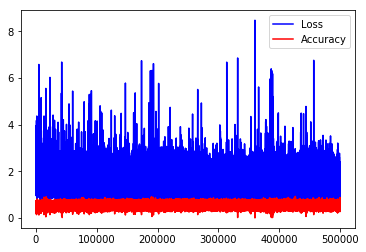

In [13]:
if TRAIN_ITERS > 0:
    # After the execution is done, plot the values.
    pyplot.plot(loss, 'b')
    pyplot.plot(accuracy, 'r')
    pyplot.legend(('Loss', 'Accuracy'), loc='upper right')
    print('Training Accuracy: %f' % accuracy.mean())
    print('Loss: %f' % loss.mean())

### Test the model

test_accuracy: 0.526074


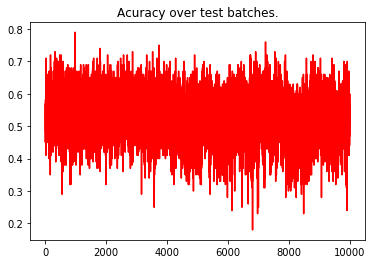

In [14]:
test_accuracy = np.zeros(TEST_ITERS)
for i in range(TEST_ITERS):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

### Save the work for future use

In [15]:
if TRAIN_ITERS > 0:
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
    # save the model to a file. Use minidb as the file format
    pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model.minidb"), pe_meta)
    print('Params saved to {}'.format(SAVE_FOLDER))

Params saved to /home/wangd/python/tutorial_data/go/param/conv=13-k=192-iter=4500000
